# Project: Traffic Sign Classifier

By Derrick Hathaway
<br/>November 11, 2017

## The Dataset

We will be training a model to classify traffice signs from the German [Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

We will start by loading our data set which has been subdivided into three subsets: a training set which will be used to train the model, a validation set that we will use to validate the progress of our training, and a test set. Once training is complete we will use the test set to determine the accuracy of our final model.

In [16]:
import pickle
import numpy as np

training_file = 'train.p'
validation_file = 'valid.p'
test_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f)

X_train_in, y_train = train['features'], train['labels'].astype(np.uint8)
X_valid_in, y_valid = valid['features'], valid['labels'].astype(np.uint8)
X_test_in, y_test = test['features'], test['labels'].astype(np.uint8)

## Preparing the Data

In order to improve training performance, we will take certain steps to condition the input data.

First we will do a histogram equalization on the image to improve contrast. This effectively spreads out the input data over a broader range.

Next, we will adjust the input data so that the range for each pixel is `(-1.0, 1.0]`.

Next we will shuffle the training data so that the features and labels are encountered by the optimizer in a random order. If the input data are ordered, this can make it difficult for our network to converge on an acceptable solution.

In [17]:
import cv2

def adjust(x):
    for i in range(len(x)):
        img_yuv = cv2.cvtColor(x[i], cv2.COLOR_RGB2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        x[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    return x.astype(np.float32) / 255

X_train = adjust(X_train_in)
X_valid = adjust(X_valid_in)
X_test = adjust(X_test_in)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

## Visualizing the Data

Below is a random sample from the training dataset.

In [18]:
import csv
sign_names = []
with open('samples/signnames.csv', 'r') as f:
    data = list(csv.reader(f))
    for i, sign_name in data:
        sign_names.append(sign_name)

def sign_name(num):
    sign_names[num]


In [19]:
n_train = len(y_train)
n_validation = len(y_valid)
n_test = len(y_test)
image_shape = X_train[0].shape
unique = np.unique(y_train)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", len(unique))

import pandas as pd

counts = pd.value_counts(pd.Series(y_train))
print(counts)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
2     2010
1     1980
13    1920
12    1890
38    1860
10    1800
4     1770
5     1650
25    1350
9     1320
7     1290
8     1260
3     1260
11    1170
18    1080
35    1080
17     990
31     690
14     690
33     599
15     540
26     540
28     480
23     450
30     390
34     360
6      360
16     360
22     330
36     330
40     300
20     300
21     270
39     270
24     240
29     240
32     210
42     210
41     210
27     210
37     180
19     180
0      180
dtype: int64


Label No passing


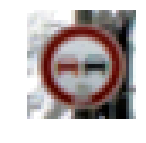

In [21]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))

plt.imshow(image)
plt.axis('off')
print("Label", sign_names[y_train[index]])

## Model Hyperparameters

These are a few of the levers we can turn to adjust the training performance. These include the batch size, the number of epochs, the dropout rate used during training, the mean and standard deviation of our initial random weights, and the learning rate.

In [22]:
EPOCHS = 8
BATCH_SIZE = 64
dropout = 0.50

mu = 0
sigma = 0.1

learn_rate = 0.001

## Helper Functions

I've created some helper functions to help make the structure of my model more readable. This was very useful during development because it allowed me to adjust the size of the layers and make other changes with confidence.

In [23]:
import tensorflow as tf

def weights(shape):
    return tf.truncated_normal(shape=shape, mean=mu, stddev=sigma)

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(
        x,
        W,
        strides=[1, strides, strides, 1],
        padding='VALID')
    
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

## The LeNet Model

I used the LeNet-5 model from the CNN Lesson as a starting point. I found that increasing the k-size of the convolution layers, as well as the size of the fully connected layers improved training performance significantly. The road sign images are more complex than black and white handwrittend digits so more depth in the convolutional layers is necessary.

In [24]:
from tensorflow.contrib.layers import flatten

weights = {
    'conv0': tf.Variable(weights([5,5,3,24])),
    'conv1': tf.Variable(weights([5,5,24,64])),
    'fc1': tf.Variable(weights([1600, 600])),
    'fc2': tf.Variable(weights([600, 200])),
    'fc3': tf.Variable(weights([200, 43])),
}

bias = {
    'conv0': tf.Variable(tf.zeros(24)),
    'conv1': tf.Variable(tf.zeros(64)),
    'fc1': tf.Variable(tf.zeros(600)),
    'fc2': tf.Variable(tf.zeros(200)),
    'fc3': tf.Variable(tf.zeros(43)),
}

def LeNet(x, dropout):
    conv_0 = conv2d(x, weights['conv0'], bias['conv0'])
    conv_0 = maxpool2d(conv_0)
    
    conv_1 = conv2d(conv_0, weights['conv1'], bias['conv1'])
    conv_1 = maxpool2d(conv_1)
    
    flat = flatten(conv_1)
    
    fc1 = tf.add(tf.matmul(flat, weights['fc1']), bias['fc1'])
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.add(tf.matmul(fc1, weights['fc2']), bias['fc2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    fc3 = tf.add(tf.matmul(fc2, weights['fc3']), bias['fc3'])
    
    return fc3

# signs dataset consists of 32x32x3 images
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
# Classify over 43 road signs labeled 0-42
y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
loss_op = tf.reduce_mean(cross_entropy)
opt = tf.train.AdamOptimizer(learning_rate=learn_rate)
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Training & Testing

### Method for Improving Performance

I started out with the basic LeNet model from the MNIST classifier I built for the CNN Lab. After adapting the shape of the network to account for the 3 color channels of the image I mostly just tried different values for various hyper parameters. Here are some of the changes I made to improve performance.

- Adjusting the learning rate. I tried values ranging from `0.01` - `0.0001`. The faster learning rates resulted in sort of erratic results, converging to a fairly high success rate, but very unpredictably. The lower learning rate did not achive a higher success rate, and converged very slowly. In the end I settled on `0.001`.
- Implementing dropout. I played around with different dropout rates before arriving at `50%`.
- Increasing the depth of the convolution layers and the width of the fully connected layers coupled with dropout also seemed to have pretty big impact on classification performance.
- Adjusting the batch size. Larger batch sizes seemed to perform better for me. And I finally settled on a batch size of 128.
- I tried various numbers of epochs, ranging from 6 to 20. I found that anything more than 10, give my other parameters tended to diverge slightly. Even now, the model will often peak in performance by about the 7th or 8th epoch. My final selection was 10 epochs.

Choosing these parameters felt sort of arbitrary. I just tried tuning each value independently to see how it affected performance. When I felt satisfied with one of the parameter's values, I would tune a different parameter. I also went back occasionally to see if changes to a later parameter effected a previously tuned parameter, tweaking it again to see if a previouly poor value might perform better under new conditions. Tuning these parameter seems like the sort of thing that a computer could perform much better at.

In [25]:
def eval_data(X_data, y_data):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    num_examples = len(y_data)
    total_acc, total_loss = 0, 0
    sess = tf.get_default_session()
    for batch in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[batch:batch + BATCH_SIZE]
        batch_y = y_data[batch:batch + BATCH_SIZE]
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples


saver = tf.train.Saver()
save_file = './train_model.ckpt'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)

    # Train model
    for i in range(EPOCHS):
        for batch in range(0, num_examples, BATCH_SIZE):
            batch_x = X_train[batch:batch+BATCH_SIZE]
            batch_y = y_train[batch:batch+BATCH_SIZE]
            loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})

        val_loss, val_acc = eval_data(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation loss = {:.3f}".format(val_loss))
        print("Validation accuracy = {:.3f}".format(val_acc))
        print()

    saver.save(sess, save_file)

EPOCH 1 ...
Validation loss = 0.429
Validation accuracy = 0.861

EPOCH 2 ...
Validation loss = 0.314
Validation accuracy = 0.907

EPOCH 3 ...
Validation loss = 0.271
Validation accuracy = 0.926

EPOCH 4 ...
Validation loss = 0.318
Validation accuracy = 0.927

EPOCH 5 ...
Validation loss = 0.276
Validation accuracy = 0.934

EPOCH 6 ...
Validation loss = 0.318
Validation accuracy = 0.936

EPOCH 7 ...
Validation loss = 0.327
Validation accuracy = 0.933

EPOCH 8 ...
Validation loss = 0.477
Validation accuracy = 0.921



In [27]:
## Testing Against Provided Test Dataset
with tf.Session() as sess:
    saver.restore(sess, save_file)   # Evaluate on the test data
    test_loss, test_acc = eval_data(X_test, y_test)
    print("Test loss = {:.3f}".format(test_loss))
    print("Test accuracy = {:.3f}".format(test_acc))

Test loss = 0.427
Test accuracy = 0.911


## Testing Against New Images

I have found a few images from the web of various German traffic signs. We will use the trained model to classify these signs. I have cropped and resized the images to match the expected input of the network.

In [28]:
import matplotlib.image as mpimg
from IPython.display import display, Markdown

top_k = tf.nn.top_k(tf.nn.softmax(logits), k=5)

def classify_image(filename):
    file = mpimg.imread(filename)
    file = file[:,:,:3]
    file = np.expand_dims(file, axis=0)
    file = file * 2.0 - 1.0
    sess = tf.get_default_session()
    result = sess.run(top_k, feed_dict={x: file, keep_prob: 1.0})
    output = """
| ![filename]({} 'file') Sign Classification | SoftMax Probabilities |
| ------------------------------ | ----------- |
"""
    print("Result: ", result.values, result.indices)
    for i in range(len(result.values[0])):
        output += "| {} | {:.5f} |\n".format(
            sign_names[result.indices[0][i]],
            result.values[0][i]
        )
    display(Markdown(output.format(filename)))
    
with tf.Session() as sess:
    saver.restore(sess, save_file)
    classify_image('samples/nopassing.png')
    
    classify_image('samples/stop.png')
    print("I'm not sure why the stop sign classification failed. I suspect converting the images to a different color space would have helped with this classification.")
    print("")
    
    classify_image('samples/yield.png')
    classify_image('samples/direction.png')
    classify_image('samples/prohibited.png')
    classify_image('samples/twenty.png')

Result:  [[  9.99872804e-01   1.27211664e-04   3.92442665e-08   2.19688512e-09
    1.55113943e-12]] [[ 9 13 12 41 15]]



| ![filename](samples/nopassing.png 'file') Sign Classification | SoftMax Probabilities |
| ------------------------------ | ----------- |
| No passing | 0.99987 |
| Yield | 0.00013 |
| Priority road | 0.00000 |
| End of no passing | 0.00000 |
| No vehicles | 0.00000 |


Result:  [[  1.00000000e+00   2.33531161e-21   6.45759518e-23   2.97783553e-25
    1.60854254e-26]] [[12 17 14 11 41]]



| ![filename](samples/stop.png 'file') Sign Classification | SoftMax Probabilities |
| ------------------------------ | ----------- |
| Priority road | 1.00000 |
| No entry | 0.00000 |
| Stop | 0.00000 |
| Right-of-way at the next intersection | 0.00000 |
| End of no passing | 0.00000 |


I'm not sure why the stop sign classification failed. I suspect converting the images to a different color space would have helped with this classification.

Result:  [[  1.00000000e+00   1.61206910e-33   0.00000000e+00   0.00000000e+00
    0.00000000e+00]] [[13  9  0  1  2]]



| ![filename](samples/yield.png 'file') Sign Classification | SoftMax Probabilities |
| ------------------------------ | ----------- |
| Yield | 1.00000 |
| No passing | 0.00000 |
| Speed limit (20km/h) | 0.00000 |
| Speed limit (30km/h) | 0.00000 |
| Speed limit (50km/h) | 0.00000 |


Result:  [[  1.00000000e+00   8.87767844e-23   2.27739636e-29   7.13354183e-33
    3.96434322e-34]] [[38 32 41 36 40]]



| ![filename](samples/direction.png 'file') Sign Classification | SoftMax Probabilities |
| ------------------------------ | ----------- |
| Keep right | 1.00000 |
| End of all speed and passing limits | 0.00000 |
| End of no passing | 0.00000 |
| Go straight or right | 0.00000 |
| Roundabout mandatory | 0.00000 |


Result:  [[  1.00000000e+00   1.47869225e-32   1.06874006e-34   0.00000000e+00
    0.00000000e+00]] [[13 38 12  0  1]]



| ![filename](samples/prohibited.png 'file') Sign Classification | SoftMax Probabilities |
| ------------------------------ | ----------- |
| Yield | 1.00000 |
| Keep right | 0.00000 |
| Priority road | 0.00000 |
| Speed limit (20km/h) | 0.00000 |
| Speed limit (30km/h) | 0.00000 |


Result:  [[  9.56342936e-01   4.08698544e-02   2.32058880e-03   4.46792546e-04
    1.09398270e-05]] [[28 32 41 40  0]]



| ![filename](samples/twenty.png 'file') Sign Classification | SoftMax Probabilities |
| ------------------------------ | ----------- |
| Children crossing | 0.95634 |
| End of all speed and passing limits | 0.04087 |
| End of no passing | 0.00232 |
| Roundabout mandatory | 0.00045 |
| Speed limit (20km/h) | 0.00001 |


## Conclusion

For my "real world" tests the model performed at 60% efficiency. This is less that I would have expected. In hindsight using a different color space would likely have yielded better results.